<a href="https://colab.research.google.com/github/FlexTaco/cs370/blob/main/assignments/assignment-3/assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch torchvision pytube opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.5 MB/s eta 0:00:00


Installing the necessary components and using the pretrained r-cnn model with the precalculated weights. we also don't need to worry about batch normalization since we don't have to train the model

In [3]:
import torch
import torchvision
from pytube import YouTube
import cv2
import matplotlib.pyplot as plt
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F


In [5]:
#ResNet50 backbone
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

Ran into some problems with PyTube library trying to download the video from YouTube and OpenCV to read and preprocess the video frames. From this link:
https://github.com/pytube/pytube/issues/2062



In [6]:
# Set the YouTube URL
# video_url = "https://www.youtube.com/watch?v=vUnuDTVHwGE"

# Download the video using PyTube
# yt = YouTube(video_url)
# video_stream = yt.streams.get_highest_resolution()
# video_path = video_stream.download(filename='sports_video.mp4')
# video_path = yt.download(filename='sports_video.mp4')
# print(f"Video downloaded to: {video_path}")


import ssl
from pytube import YouTube
from pytube import request
from pytube import extract
from pytube.innertube import _default_clients
from pytube.exceptions import RegexMatchError

_default_clients["ANDROID"]["context"]["client"]["clientVersion"] = "19.08.35"
_default_clients["IOS"]["context"]["client"]["clientVersion"] = "19.08.35"
_default_clients["ANDROID_EMBED"]["context"]["client"]["clientVersion"] = "19.08.35"
_default_clients["IOS_EMBED"]["context"]["client"]["clientVersion"] = "19.08.35"
_default_clients["IOS_MUSIC"]["context"]["client"]["clientVersion"] = "6.41"
_default_clients["ANDROID_MUSIC"] = _default_clients["ANDROID"]

import pytube, re
def patched_get_throttling_function_name(js: str) -> str:
    function_patterns = [
        r'a\.[a-zA-Z]\s*&&\s*\([a-z]\s*=\s*a\.get\("n"\)\)\s*&&.*?\|\|\s*([a-z]+)',
        r'\([a-z]\s*=\s*([a-zA-Z0-9$]+)(\[\d+\])?\([a-z]\)',
        r'\([a-z]\s*=\s*([a-zA-Z0-9$]+)(\[\d+\])\([a-z]\)',
    ]
    for pattern in function_patterns:
        regex = re.compile(pattern)
        function_match = regex.search(js)
        if function_match:
            if len(function_match.groups()) == 1:
                return function_match.group(1)
            idx = function_match.group(2)
            if idx:
                idx = idx.strip("[]")
                array = re.search(
                    r'var {nfunc}\s*=\s*(\[.+?\]);'.format(
                        nfunc=re.escape(function_match.group(1))),
                    js
                )
                if array:
                    array = array.group(1).strip("[]").split(",")
                    array = [x.strip() for x in array]
                    return array[int(idx)]

    raise RegexMatchError(
        caller="get_throttling_function_name", pattern="multiple"
    )

ssl._create_default_https_context = ssl._create_unverified_context
pytube.cipher.get_throttling_function_name = patched_get_throttling_function_name

yt = YouTube("https://www.youtube.com/watch?v=vUnuDTVHwGE")
audio_stream = yt.streams.filter(only_audio=True).first()
audio_filename = audio_stream.download(output_path = "./output")

Video downloaded to: /content/sports_video.mp4


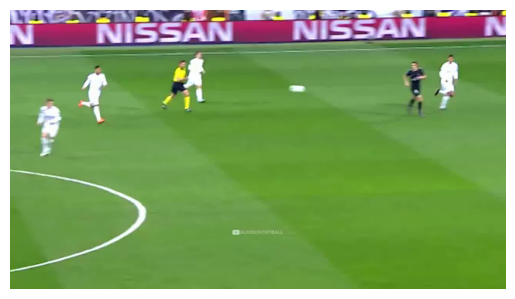

In [13]:

#download the video
video_url = "https://www.youtube.com/watch?v=vUnuDTVHwGE"
yt = YouTube(video_url)
video_stream = yt.streams.get_highest_resolution()
video_path = video_stream.download(filename='sports_video.mp4')
print(f"Downloaded to: {video_path}")

video = cv2.VideoCapture(video_path)

#we are getting one frame but we will do more later on
success, frame = video.read()

#Check if frame was read successfully
if success:
  frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  plt.imshow(frame_rgb)
  plt.axis("off")
  plt.show()
else:
  print("Failed to get frame")

Below we will try to get the frame we just got into a matrix representation to extract certian features for our visualization. this makes it easier to ensure that the input size is that required for the Faster R-CNN to work. The backbone of this extraction requires the use a ResNet model. The model uses Feature Pyramid Network(FPN) which is a extraction network that efficiently extracts features at multiple scales. It combines a top down pathways with lateral connections to propagate high level semantic information to lower level features. This helps assist in better feature representation.





In [14]:
frame_tensor = F.to_tensor(frame_rgb)
frame_tensor = frame_tensor.unsqueeze(0)


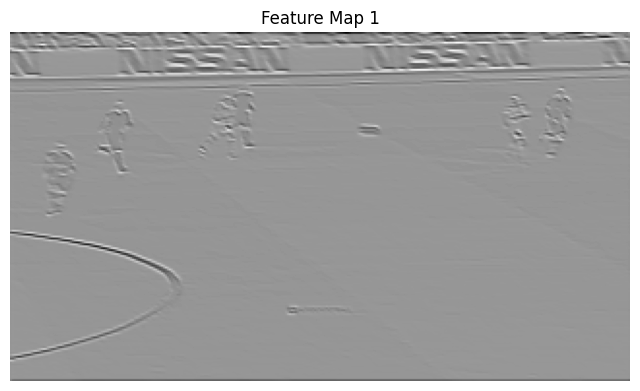

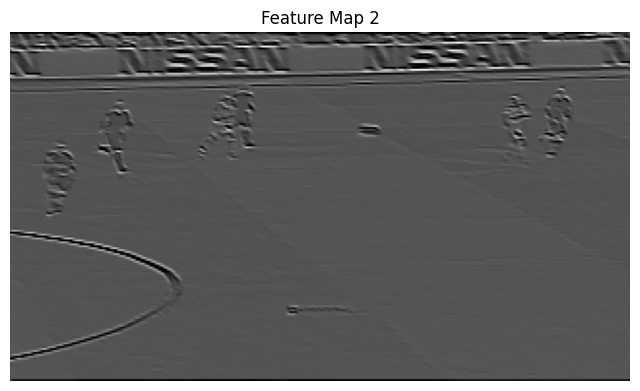

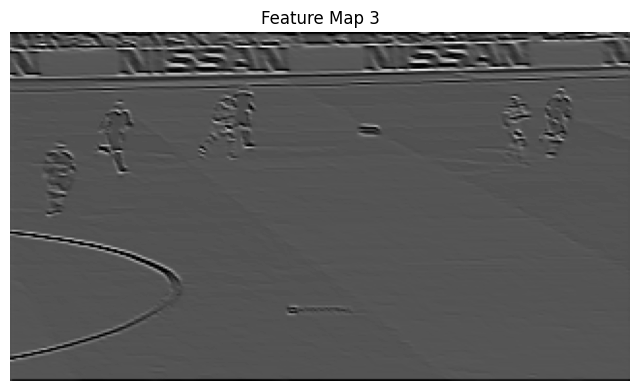

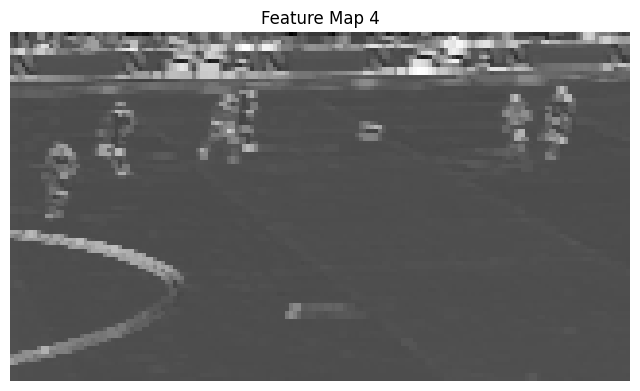

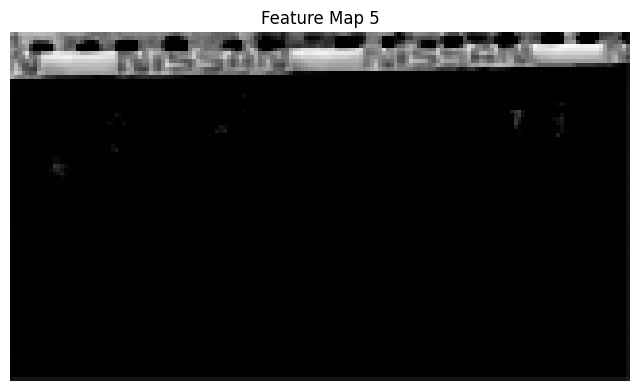

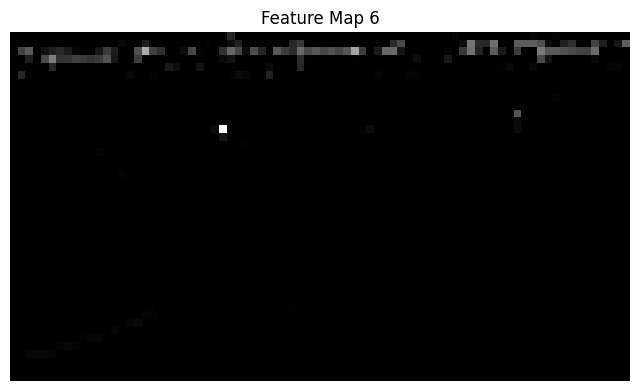

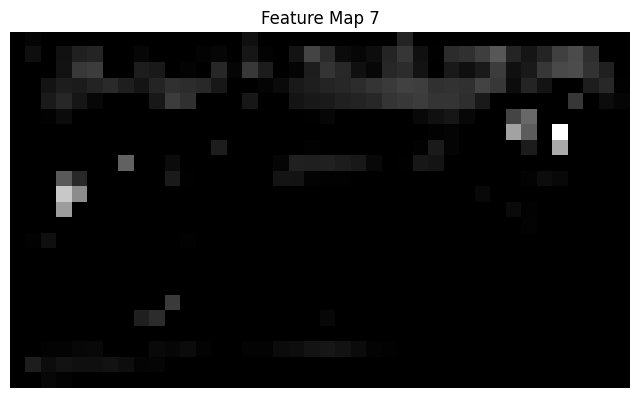

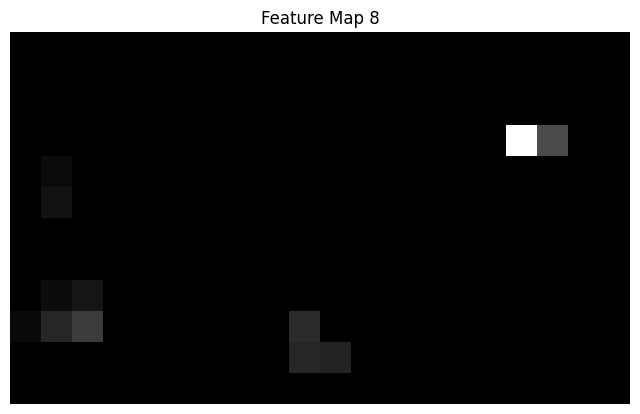

In [15]:
def get_feature_maps(model, input_tensor):
    feature_maps = []
    hooks = []

    for layer in model.backbone.body.children():
        hooks.append(layer.register_forward_hook(lambda _, __, output: feature_maps.append(output)))

    with torch.no_grad():
        _ = model.backbone(input_tensor)

    for hook in hooks:
        hook.remove()

    return feature_maps

feature_maps = get_feature_maps(model, frame_tensor)
for i, fmap in enumerate(feature_maps):
    plt.figure(figsize=(8, 8))
    plt.imshow(fmap[0][0].cpu().numpy(), cmap='gray')
    plt.title(f"Feature Map {i+1}")
    plt.axis("off")
    plt.show()


The Region Proposal Network(RPN) takes in a feature maps from the backbone and generates a set of regions that may contain objects. A score is assigned based on how likely a region is to contain an object. This is where we see the bounding boxes in our frame.



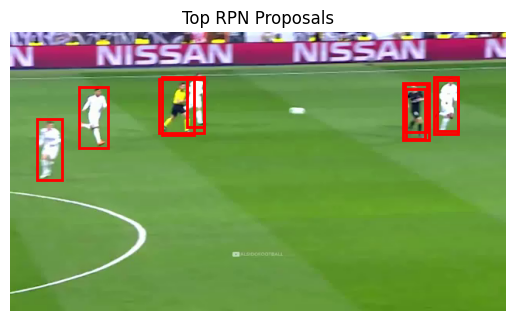

In [20]:
!pip install torchvision
import torch
from torchvision.models.detection.image_list import ImageList

with torch.no_grad():
    features = model.backbone(frame_tensor)

image_sizes = [(frame_tensor.shape[-2], frame_tensor.shape[-1])]
image_list = ImageList(frame_tensor, image_sizes)

with torch.no_grad():
    proposals, _ = model.rpn(image_list, features)

plt.imshow(frame_rgb)
#can change to see the top 5 or top N propsoal but currently set to 10
for box in proposals[0][:10]:
    x1, y1, x2, y2 = box.int().numpy()
    plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2))
plt.axis("off")
plt.title("Top RPN Proposals")
plt.show()

The regions are classified into 2 different objects(player or ball) or as background. Bounding box regression adjusts the proposed region to more accurately fit the object. Each box has a confidence score of whether there is truely an object within the box. We also only show boxes with a score greater than 80 but this number can be adjusted to your preference.

One thign to note about pooling:
For each region, Faster R-CNN applies ROI Pooling. This extracts fixed size features from each region for further processing. This step enables the model to process regions at a uniform scale. ROI pooling is already applied within the pretrained Faster R-CNN model so we don't need to write it.

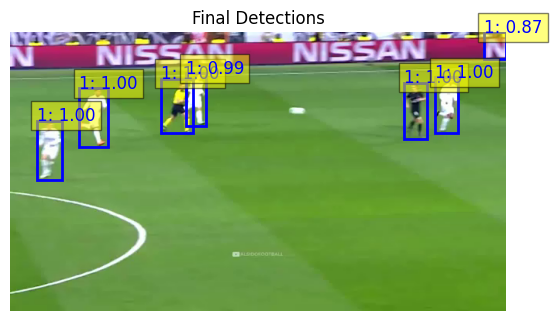

In [21]:
with torch.no_grad():
    detections = model(frame_tensor)

#show detections on the frame
plt.imshow(frame_rgb)
for i, box in enumerate(detections[0]['boxes']):
    x1, y1, x2, y2 = box.int().numpy()
    label = detections[0]['labels'][i].item()
    score = detections[0]['scores'][i].item()

    if score > 0.8:
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='blue', linewidth=2))
        plt.text(x1, y1, f"{label}: {score:.2f}", color="blue", fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))

plt.axis("off")
plt.title("Final Detections")
plt.show()


Below instead of going through 1 frame we are gonna go through 40 frames by 10 frame increments. this step lets us visualize the process over multiple frames to see how the detection performs over time. this highlighta the multi object tracking aspect of the model.


In [27]:
#you can adjust these numbers
frame_skip = 10
frame_count = 0
max_frames = 5
processed_frames = []

while video.isOpened() and len(processed_frames) < max_frames:
    success, frame = video.read()
    if not success:
        break

     #run the model for every 10 frames
    if frame_count % frame_skip == 0:
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_tensor = F.to_tensor(frame_rgb).unsqueeze(0)
        with torch.no_grad():
            detections = model(frame_tensor)
        #adding to our result array
        processed_frames.append((frame_rgb, detections))

    frame_count += 1

video.release()


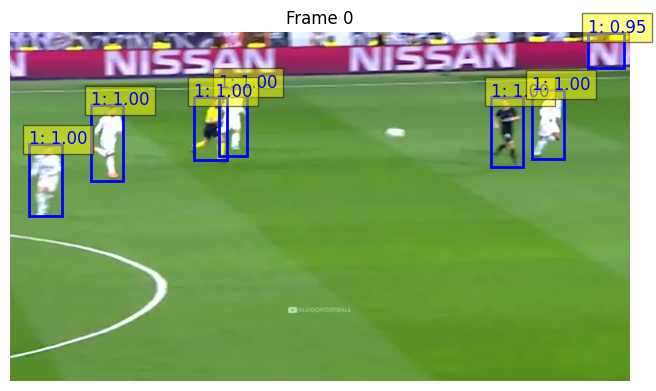

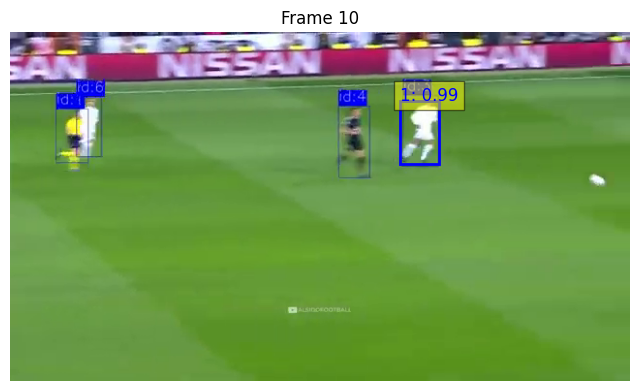

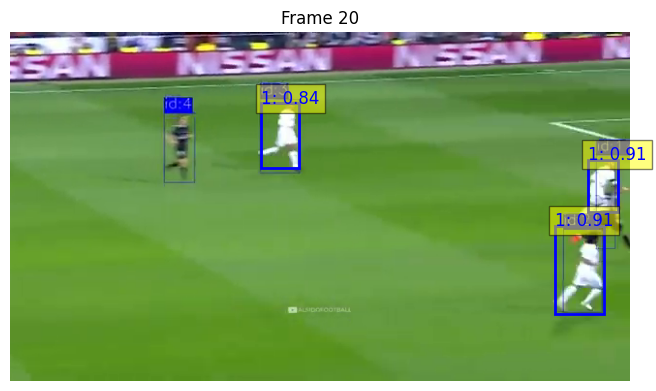

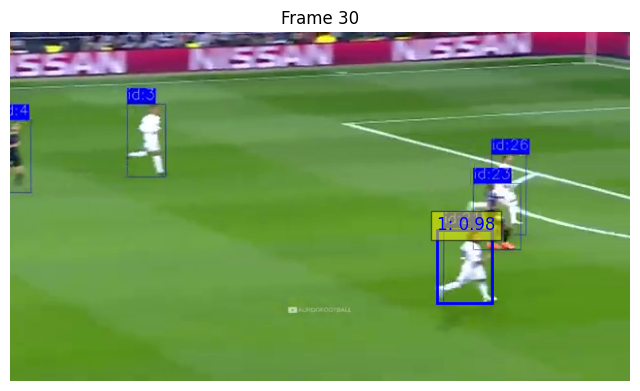

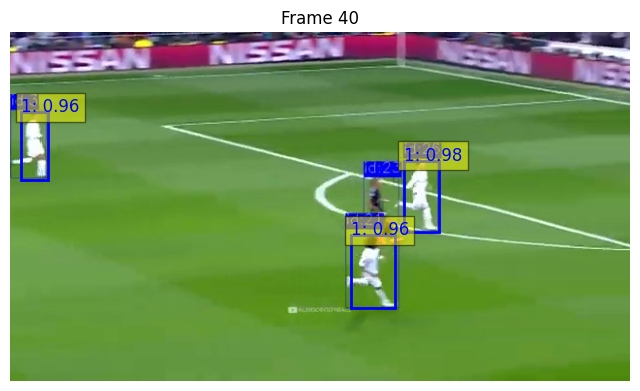

In [28]:
#just looping through our result array to add the boxes
#can change some of the size and color to help better distingush, but should be good enough as is
for i, (frame_rgb, detections) in enumerate(processed_frames):
    plt.figure(figsize=(8, 6))
    plt.imshow(frame_rgb)

    for j, box in enumerate(detections[0]['boxes']):
        x1, y1, x2, y2 = box.int().numpy()
        label = detections[0]['labels'][j].item()
        score = detections[0]['scores'][j].item()

        if score > 0.8:
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='blue', linewidth=2))
            plt.text(x1, y1, f"{label}: {score:.2f}", color="blue", fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis("off")
    plt.title(f"Frame {i * frame_skip}")
    plt.show()
